In [1]:
import os
import pandas as pd
import numpy as np
import glob

desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 10)

In [2]:
##############################################################################
# Load and clean Rating data                                                 #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\Rating.csv'
df_ratings_raw = pd.read_csv(path)

# drop RatingSPOutlook,RatingSPOutlook columns
df_ratings_no_xtra_col = df_ratings_raw.drop(columns=['RatingSPOutlook', 'RatingSPOutlook.1'])

# drop NA from RatingSP column
df_ratings_clean = df_ratings_no_xtra_col.dropna(subset=['RatingSP'])

# calculate mean per security by removing KeyDate
df_ratings_clean = df_ratings_clean.drop(columns=['KeyDate'])
df_ratings_with_mean = df_ratings_clean.groupby(['SecurityID']).mean()
df_ratings_with_mean.reset_index()

,SecurityID,RatingSP
0,64,10.000000
1,72,13.000000
2,78,14.652361
3,82,15.000000
4,83,14.652361
...,...,...
17918,72406,14.000000
17919,72407,14.000000
17920,72504,17.000000
17921,72675,8.000000


In [3]:
##############################################################################
# Load and clean Spreads data                                                #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\raw_data_files'
all_files = glob.glob(os.path.join(path, "*.csv"))  # use os.path.join to make concat OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True, sort=False)

In [4]:
# drop na from spreads data
df_merged = df_merged.dropna(how='any')
# convert dates to Date type
df_merged['KeyDate'] = pd.to_datetime(df_merged['KeyDate'], errors='coerce')

# Extract the low liers
dates_low_liers = df_merged["KeyDate"].value_counts()
dates_low_liers = dates_low_liers[dates_low_liers < 500]

# clean the dataset by removing the low liers and NaNs
df_merged_clean = df_merged[~df_merged['KeyDate'].isin(dates_low_liers.index)]

# drop KeyDate column
df_data_values = df_merged_clean.drop(columns=['KeyDate'])

# group by security and average all other columns
df_data_values_with_mean = df_data_values.groupby(['SecurityID']).mean()
df_data_values_with_mean.reset_index()

,SecurityID,Price,YieldWorst,ModifiedDuration_Plain,AmtOutstanding,GSpread,OAS_Spread,ZSpread,AswUsd
0,64,100.758965,4.644316,5.757035,1.697266e+09,291.711174,222.352441,288.657755,283.687773
1,72,107.373280,3.940311,3.330841,1.000000e+09,227.002913,223.490338,223.329880,229.235868
2,78,103.207920,3.477836,1.945063,8.000000e+08,180.855440,176.403676,171.764407,169.003940
3,82,115.672100,4.473227,14.990642,2.000000e+09,217.044085,215.316896,245.880015,265.958284
4,83,106.167899,3.416090,1.207811,1.000000e+09,171.659279,164.354293,154.729040,157.830712
...,...,...,...,...,...,...,...,...,...
19808,72944,95.239076,4.044686,4.417710,7.500000e+08,366.768519,361.804353,356.978706,342.727059
19809,72948,90.060159,11.504231,2.250852,4.000000e+08,1124.316903,1120.898118,1109.677059,1022.199941
19810,72949,88.003900,6.550267,55.330667,5.000000e+08,500.722641,566.272333,595.348333,614.242667
19811,72950,90.583533,7.934610,53.381167,3.000000e+08,639.156975,697.474333,733.633667,621.808000


In [5]:
##############################################################################
# Load and clean Securities meta data                                        #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\SecurityData.csv'  # use your path
df_securities = pd.read_csv(path)

# filter out CountryDomicile=US
df_securities_US = df_securities.loc[df_securities['CountryDomicile'] == 'US']

In [6]:
##############################################################################
# Merge all the datasets into one DataFrame / File                           #
##############################################################################

# left join RatingSP from df_rating on df_securities and replace NA with zero
df_securities_US_w_avg_rating = df_securities_US.merge(df_ratings_with_mean, on=['SecurityID'], how='left')
df_securities_US_w_avg_rating['RatingSP'] = df_securities_US_w_avg_rating['RatingSP'].fillna(0)


# left join all columns by SecurityID from df_avg_data_values into df_securities_US_w_avg_rating
df_securities_US_w_data = df_securities_US_w_avg_rating.merge(df_data_values_with_mean, on=['SecurityID'], how='left')

# drop rows from df_securities_US_w_data without average spreads
df_securities_US_w_data_clean = df_securities_US_w_data.dropna(subset=['Price', 'YieldWorst', 'ModifiedDuration_Plain',
                                                                       'AmtOutstanding', 'GSpread', 'OAS_Spread', 'ZSpread', 'AswUsd'])

# TEMP - output df_securities to US_Securities_with_AVG_Rating_AVG_Spreads.csv
df_securities_US_w_data_clean.to_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\US_Securities_with_AVG_Rating_AVG_Spreads.csv')


In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from scipy.spatial.distance import cdist

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time

%matplotlib inline

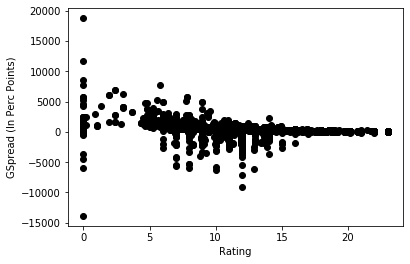

In [8]:
X = df_securities_US_w_data_clean[["RatingSP","GSpread"]]
#Visualise data points
plt.scatter(X["RatingSP"],X["GSpread"],c='black')
plt.xlabel('Rating')
plt.ylabel('GSpread (In Perc Points)')
plt.show()

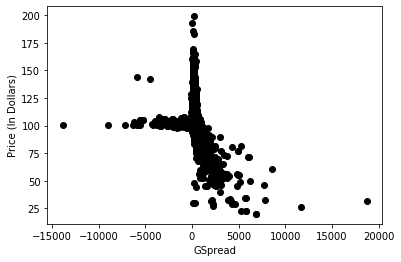

In [9]:
X = df_securities_US_w_data_clean[["GSpread","Price"]]
#Visualise data points
plt.scatter(X["GSpread"],X["Price"],c='black')
plt.xlabel('GSpread')
plt.ylabel('Price (In Dollars)')
plt.show()

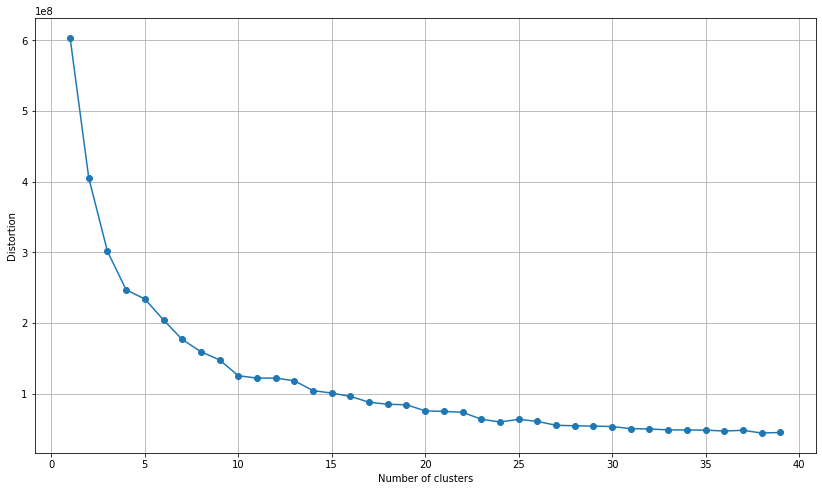

In [46]:
K = range(1,40)
df = df_securities_US_w_data_clean[['GSpread', 'RatingSP', 'YieldWorst', 'Price',
                                    'AmtOutstanding', 'OAS_Spread', 'ZSpread', 'AswUsd', 'AmountIssued']]

distortions = []
for k in K:
    km = KMeans(
        n_clusters=k, init='k-means++',
        n_init=30, max_iter=500, random_state=42
    ).fit(df)
    km.fit(df)
    distortions.append(sum(np.min(cdist(df, km.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])


plt.figure(figsize=(14,8))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')    
plt.plot(K, distortions, marker='o')
plt.grid()
plt.show()


In [47]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df)
centroids_gspread = kmeans.cluster_centers_
inertias_gspread = kmeans.inertia_
print(centroids_gspread)
print(inertias_gspread)


[[2.46397010e+02 1.44062762e+01 4.18461008e+00 1.03047308e+02 4.59280272e+08 2.25659039e+02 2.48683893e+02 2.37533453e+02 4.77789684e+08]
 [1.28412520e+02 1.63225126e+01 2.97810758e+00 1.05202866e+02 2.72553898e+09 1.20190153e+02 1.29866298e+02 1.47942689e+02 2.77331482e+09]
 [1.86298698e+02 1.52092788e+01 3.49391670e+00 1.04173101e+02 1.33646394e+09 1.68469305e+02 1.86902285e+02 2.04457360e+02 1.40247796e+09]
 [2.12075829e+02 1.61404845e+01 3.75801013e+00 1.06631044e+02 3.71982412e+09 2.04922111e+02 2.19897730e+02 2.13908389e+02 4.03673125e+09]
 [1.19308846e+02 1.67142857e+01 3.12869440e+00 1.10332603e+02 1.45419562e+09 1.15654050e+02 1.25019212e+02 1.33802363e+02 1.03729037e+10]
 [2.35085987e+02 1.46860076e+01 4.00790866e+00 1.02977547e+02 6.78211799e+08 2.14291861e+02 2.35900542e+02 2.26424535e+02 7.10673092e+08]
 [1.50128134e+02 1.54830425e+01 3.24131208e+00 1.05149334e+02 1.92019480e+09 1.32412843e+02 1.52686352e+02 1.36511797e+02 2.02564025e+09]
 [2.31072927e+02 1.38112999e+01 4.

In [48]:
preds = kmeans.fit_predict(df)
print(len(preds))

# df_securities_US_w_data_clean
df_test = df_securities_US_w_data_clean.copy()

df_test['ClusterTag'] = pd.Series(preds, index=df_test.index)
df_test.to_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\df_test.csv')

12219


[[   131.46809796    107.14026509]
 [  5492.53585632     46.32991513]
 [ -5340.87849951    107.36202845]
 [  1005.19826091     87.83512166]
 [ 15223.54407221     29.24386429]
 [ -2410.38351445    102.09407442]
 [-11462.41212351    100.60281644]
 [  -866.9871676     101.41888616]
 [   404.41951215    101.14717578]
 [  2450.10771107     61.68322901]]
250909715.14793348


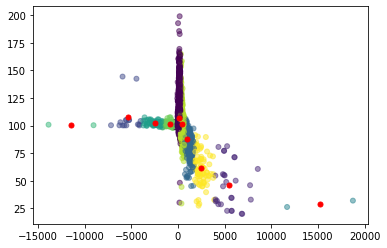

In [49]:
# Visualization only
df_2 = df[['GSpread', 'Price']]

kmeans2 = KMeans(n_clusters=10, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df_2)
centroids_kmeans2 = kmeans2.cluster_centers_
inertias_kmeans2 = kmeans2.inertia_
print(centroids_kmeans2)
print(inertias_kmeans2)

plt.scatter(df_2['GSpread'], df_2['Price'], c= kmeans2.labels_.astype(float), s=25, alpha=0.5)
plt.scatter(centroids_kmeans2[:, 0], centroids_kmeans2[:, 1], c='red', s=25)
plt.show()

[[ 1.30321961e+02  1.59003313e+01]
 [ 2.45010771e+03  5.73766654e+00]
 [-2.49435017e+03  1.06729176e+01]
 [ 1.52235441e+04  0.00000000e+00]
 [ 5.49253586e+03  3.62332138e+00]
 [-8.88441575e+02  1.09417169e+01]
 [ 3.99478035e+02  1.16348240e+01]
 [-5.87161335e+03  8.13639163e+00]
 [ 1.00006397e+03  8.32992201e+00]
 [-1.38744269e+04  0.00000000e+00]]
251571439.07021892


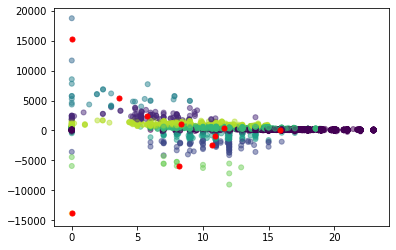

In [50]:
# Visualization only
df_3 = df[['GSpread', 'RatingSP']]

kmeans3 = KMeans(n_clusters=10, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df_3)
centroids_kmeans3 = kmeans3.cluster_centers_
inertias_kmeans3 = kmeans3.inertia_
print(centroids_kmeans3)
print(inertias_kmeans3)

plt.scatter(df_3['RatingSP'], df_3['GSpread'], c= kmeans3.labels_.astype(float), s=25, alpha=0.5)
plt.scatter(centroids_kmeans3[:, 1], centroids_kmeans3[:, 0], c='red', s=25)
plt.show()

In [51]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 


K = range(1,40)

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df) 
    kmeanModel.fit(df)     
      
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

    

In [52]:
# Tabulate the different values of Distortion
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 603610887.7233679
2 : 405230668.9045197
3 : 301335852.1408391
4 : 246985231.10207963
5 : 234049861.97810018
6 : 204304707.32714045
7 : 176761895.16267982
8 : 159501181.27886617
9 : 147818002.8963398
10 : 125539344.48473774
11 : 122093891.9207548
12 : 122172802.31190445
13 : 118391956.09188625
14 : 104397112.6381512
15 : 100934939.3848481
16 : 96282526.79649983
17 : 87977085.66457847
18 : 85114555.89721188
19 : 84377435.58273022
20 : 75847254.73131153
21 : 74994684.5290462
22 : 73741711.02596024
23 : 63973476.191502675
24 : 59992557.706651725
25 : 63806975.43548626
26 : 60906009.43330441
27 : 55418819.080812775
28 : 54667508.93538504
29 : 54242207.87975064
30 : 53605452.86175112
31 : 50678240.43632914
32 : 50124088.34268618
33 : 48891331.673310116
34 : 48737013.1466288
35 : 48515004.50684191
36 : 47287699.054684184
37 : 48284087.77957354
38 : 44424725.65354036
39 : 45228409.26667335


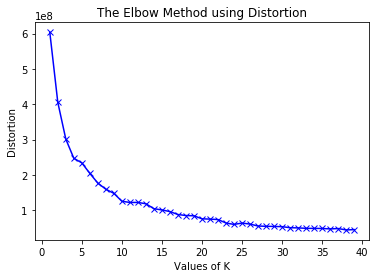

In [53]:
# Visualize the different values of Distortion
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [54]:
# Tabulate the different values of Inertia
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 1.0706813318388582e+22
2 : 4.5250972655043e+21
3 : 2.6958951392285777e+21
4 : 1.9106980411430512e+21
5 : 1.4647739179902207e+21
6 : 1.1740002616444385e+21
7 : 9.773707222554201e+20
8 : 7.861873355599481e+20
9 : 6.76213960563721e+20
10 : 5.8871332165821314e+20
11 : 5.226256716696491e+20
12 : 4.753964994521269e+20
13 : 4.122752201282125e+20
14 : 3.78930192708215e+20
15 : 3.4798625654625776e+20
16 : 3.162243381097298e+20
17 : 2.8929307477606764e+20
18 : 2.6471632732903293e+20
19 : 2.4503591033439122e+20
20 : 2.2692812467476293e+20
21 : 2.1050980563408077e+20
22 : 1.9333396086105974e+20
23 : 1.8154110471759574e+20
24 : 1.6993422422313982e+20
25 : 1.6336301958941583e+20
26 : 1.5098886834021623e+20
27 : 1.405598034040571e+20
28 : 1.3332373252147121e+20
29 : 1.2496984442282141e+20
30 : 1.2008388747891556e+20
31 : 1.1263209198890325e+20
32 : 1.0696642756726745e+20
33 : 1.0105303231201526e+20
34 : 9.971969897868191e+19
35 : 9.450061513849178e+19
36 : 9.143549075310987e+19
37 : 8.67044598969

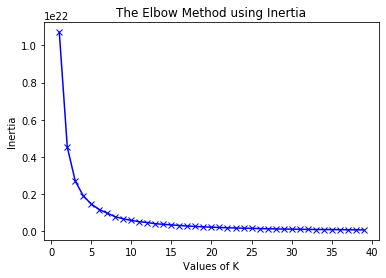

In [55]:
# Visualize the different values of Inertia
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 